anamoly detection 

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
df = pd.read_csv(r"C:\Users\sambi\Downloads\iot_manufacturing_anomaly_dataset.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Timestamp    1000 non-null   object 
 1   Temperature  1000 non-null   float64
 2   Pressure     1000 non-null   float64
 3   Vibration    1000 non-null   float64
 4   Current      1000 non-null   float64
 5   Speed        1000 non-null   float64
 6   Anomaly      1000 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 54.8+ KB


In [8]:
df.head()

,Timestamp,Temperature,Pressure,Vibration,Current,Speed,Anomaly
0,2025-01-01 00:00:00,72.48,1.780,0.432,1.43,1413.7,0
1,2025-01-01 00:01:00,91.21,4.133,2.170,4.66,961.2,1
2,2025-01-01 00:02:00,73.24,1.512,0.421,1.88,1501.8,0
3,2025-01-01 00:03:00,77.62,1.371,0.469,2.57,1547.3,0
4,2025-01-01 00:04:00,68.83,1.640,0.311,2.17,1363.3,0


In [10]:
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nAnomaly distribution:\n", df['Anomaly'].value_counts())

Shape: (1000, 7)

Missing values:
 Timestamp      0
Temperature    0
Pressure       0
Vibration      0
Current        0
Speed          0
Anomaly        0
dtype: int64

Anomaly distribution:
 Anomaly
0    950
1     50
Name: count, dtype: int64


In [12]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Temperature,1000.0,71.213040,6.816540,56.520,67.04750,70.435,73.85500,106.690
Pressure,1000.0,1.612996,0.489209,0.912,1.39075,1.525,1.67900,4.508
Vibration,1000.0,0.571943,0.331980,0.198,0.43875,0.508,0.57725,2.450
Current,1000.0,2.107820,0.586563,1.120,1.79000,2.020,2.25000,5.400
Speed,1000.0,1472.510400,139.012174,730.100,1415.47500,1491.900,1559.35000,1811.300
Anomaly,1000.0,0.050000,0.218054,0.000,0.00000,0.000,0.00000,1.000


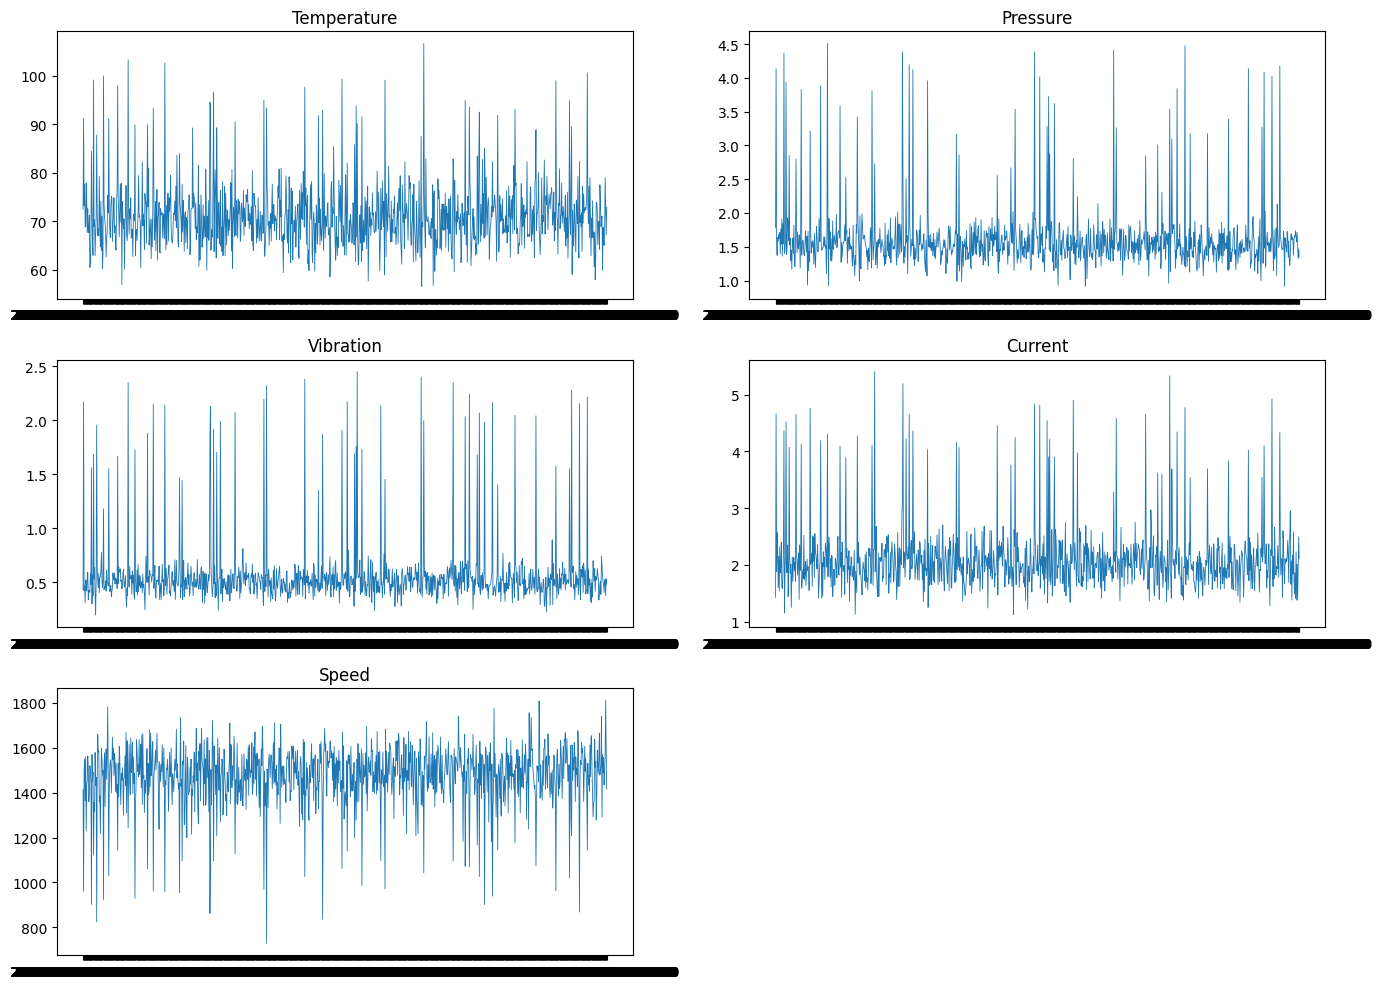

In [14]:
plt.figure(figsize=(14,10))
cols = ['Temperature', 'Pressure', 'Vibration', 'Current', 'Speed']
for i, col in enumerate(cols, 1):
    plt.subplot(3,2,i)
    plt.plot(df['Timestamp'], df[col], lw=0.6)
    plt.title(col)
plt.tight_layout()
plt.show()

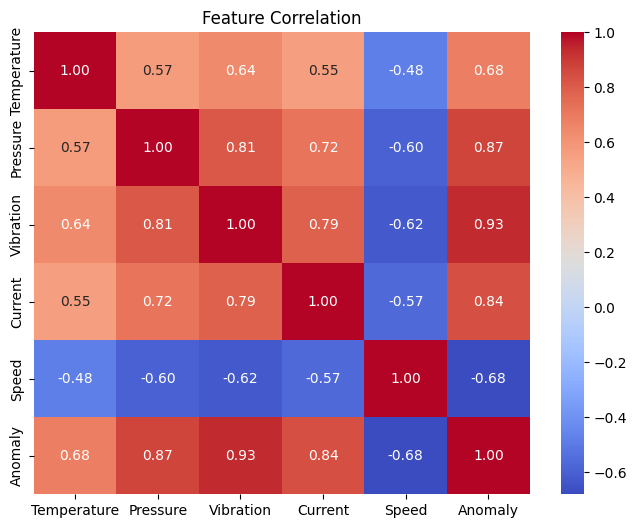

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(df[cols + ['Anomaly']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


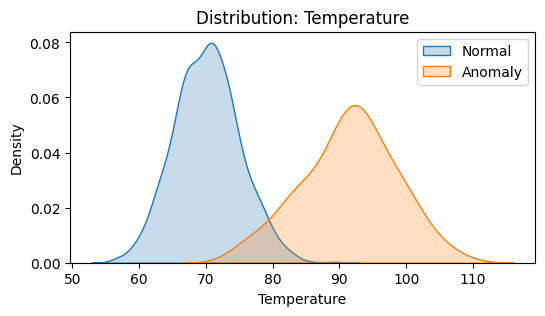

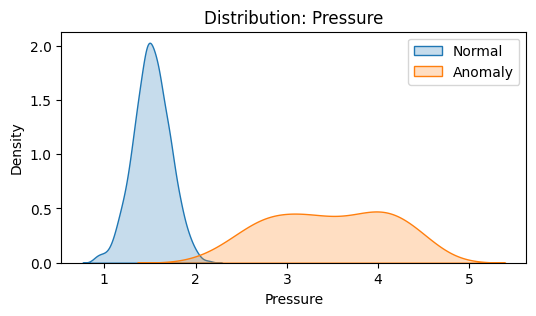

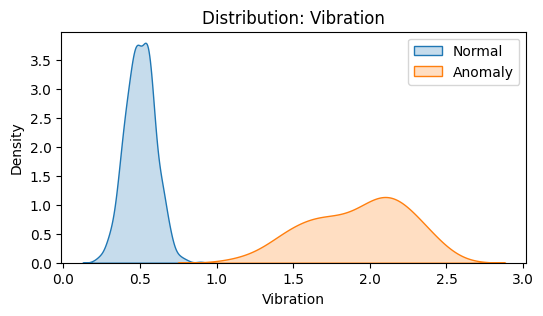

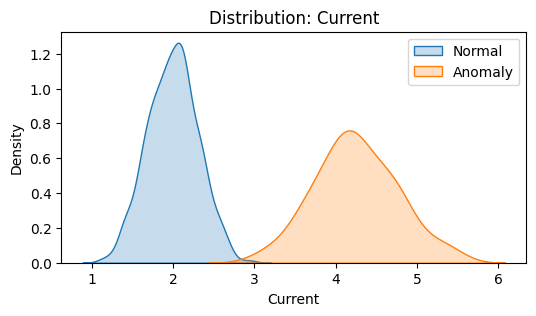

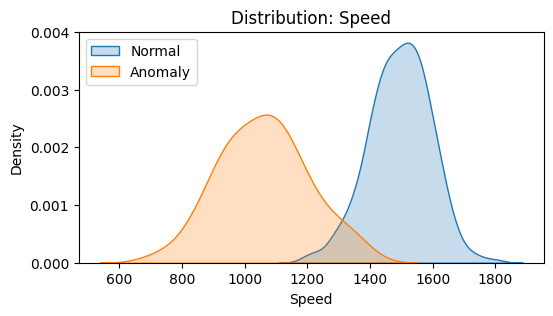

In [18]:
for col in cols:
    plt.figure(figsize=(6,3))
    sns.kdeplot(df[df['Anomaly']==0][col], label='Normal', fill=True)
    sns.kdeplot(df[df['Anomaly']==1][col], label='Anomaly', fill=True)
    plt.title(f"Distribution: {col}")
    plt.legend()
    plt.show()

- Use only sensor features for the autoencoder.
- Scale features with MinMaxScaler (0-1).
- Train the autoencoder using *only normal* samples (Anomaly == 0).

In [22]:
features = ['Temperature', 'Pressure', 'Vibration', 'Current', 'Speed']
X = df[features].values
y = df['Anomaly'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
os.makedirs('artifacts', exist_ok=True)
joblib.dump(scaler, 'artifacts/minmax_scaler.save')
print("Scaler saved to artifacts/minmax_scaler.save")

# Prepare training set: train only on normal samples
X_train = X_scaled[df['Anomaly'] == 0]
X_test = X_scaled  # we'll use whole dataset for evaluation

print("X_train (normal only) shape:", X_train.shape)
print("X_test (all samples) shape:", X_test.shape)

Scaler saved to artifacts/minmax_scaler.save
X_train (normal only) shape: (950, 5)
X_test (all samples) shape: (1000, 5)


Small dense autoencoder with symmetric encoder/decoder.
We use `sigmoid` output because inputs are scaled to [0,1] by MinMaxScaler.
Loss = mean squared error (MSE).

In [28]:
input_dim = X_train.shape[1]
encoding_dim = 3  # bottleneck size

inputs = keras.Input(shape=(input_dim,), name='input')
x = layers.Dense(16, activation='relu')(inputs)
x = layers.Dense(8, activation='relu')(x)
encoded = layers.Dense(encoding_dim, activation='relu', name='encoded')(x)

x = layers.Dense(8, activation='relu')(encoded)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='sigmoid', name='output')(x)

autoencoder = keras.Model(inputs, outputs, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded (Dense)                      │ (None, 3)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 520 (2.03 KB)

 Trainable params: 520 (2.03 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
EPOCHS = 60
BATCH = 32

history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=0.1,
    shuffle=True,
    verbose=2
)

Epoch 1/60
27/27 - 1s - 43ms/step - loss: 0.0871 - val_loss: 0.0831
Epoch 2/60
27/27 - 0s - 3ms/step - loss: 0.0766 - val_loss: 0.0697
Epoch 3/60
27/27 - 0s - 3ms/step - loss: 0.0605 - val_loss: 0.0489
Epoch 4/60
27/27 - 0s - 4ms/step - loss: 0.0367 - val_loss: 0.0231
Epoch 5/60
27/27 - 0s - 3ms/step - loss: 0.0169 - val_loss: 0.0106
Epoch 6/60
27/27 - 0s - 3ms/step - loss: 0.0086 - val_loss: 0.0064
Epoch 7/60
27/27 - 0s - 3ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 8/60
27/27 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 9/60
27/27 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 10/60
27/27 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 11/60
27/27 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 12/60
27/27 - 0s - 3ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 13/60
27/27 - 0s - 4ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 14/60
27/27 - 0s - 4ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 15/60
27/27 - 0s - 3ms/step - loss: 0.0048 - val_l

In [49]:
autoencoder.save('artifacts/autoencoder_iot_model.keras')
print("✅ Autoencoder saved successfully at artifacts/autoencoder_iot_model.keras")

✅ Autoencoder saved successfully at artifacts/autoencoder_iot_model.keras


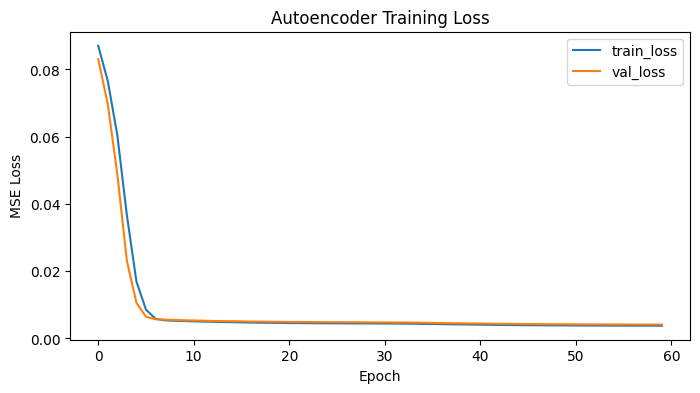

In [38]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()

## Evaluation
- Compute reconstruction error for all samples.
- Choose threshold based on training reconstruction error quantile (e.g., 95th percentile).
- Flag as anomaly if reconstruction error > threshold.

In [41]:
X_test_pred = autoencoder.predict(X_test)
recon_error = np.mean(np.square(X_test - X_test_pred), axis=1)

df['recon_error'] = recon_error

# Compute threshold from train errors (95th percentile)
train_pred = autoencoder.predict(X_train)
train_recon = np.mean(np.square(X_train - train_pred), axis=1)
threshold = np.percentile(train_recon, 95)  # you can change percentile
print("Threshold (95th percentile of train_recon):", threshold)

# Predictions
df['pred_autoenc'] = (df['recon_error'] > threshold).astype(int)

# Save df for inspection
df.to_csv('artifacts/iot_results_with_recon.csv', index=False)
print("Saved results to artifacts/iot_results_with_recon.csv")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold (95th percentile of train_recon): 0.009960581355103783
Saved results to artifacts/iot_results_with_recon.csv


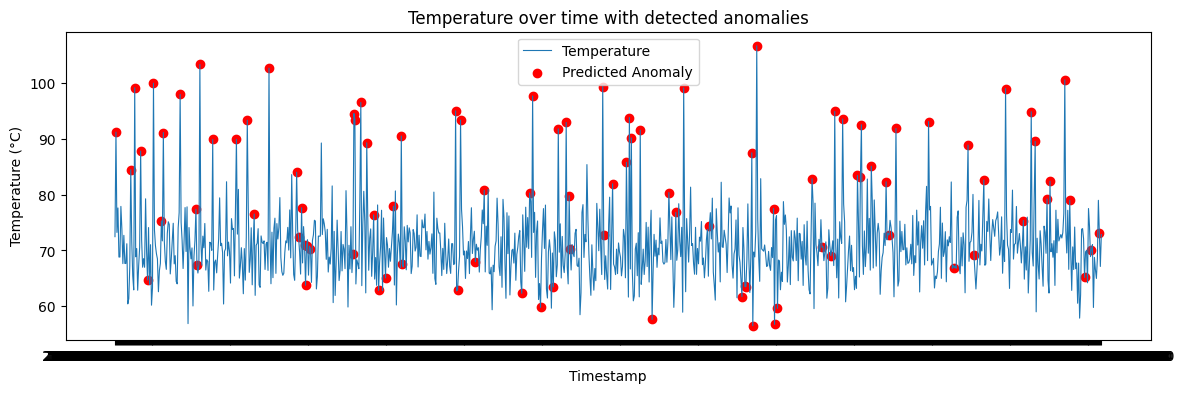

In [43]:
# Plot time series with anomalies flagged
plt.figure(figsize=(14,4))
plt.plot(df['Timestamp'], df['Temperature'], label='Temperature', lw=0.8)
anom = df[df['pred_autoenc'] == 1]
plt.scatter(anom['Timestamp'], anom['Temperature'], color='red', label='Predicted Anomaly')
plt.xlabel('Timestamp'); plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Temperature over time with detected anomalies')
plt.show()


In [45]:

print("\nClassification Report:")
print(classification_report(df['Anomaly'], df['pred_autoenc']))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       950
           1       0.51      1.00      0.68        50

    accuracy                           0.95      1000
   macro avg       0.76      0.97      0.82      1000
weighted avg       0.98      0.95      0.96      1000

